# Football Analytics: Shot Map
Apa yang akan kita lakukan dalam workshop ini:
1. Scraping data 30 pertandingan terakhir Chelsea FC dari Sofascore
2. Membuat visualisasi shot map statis dengan Python
3. Membuat visualisasi shot map interaktif dengan Looker Studio

## Install Library dan Import

In [ ]:
!pip install cloudscraper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.2 MB/s eta 0:00:00


In [ ]:
!pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.1 MB/s eta 0:00:00


In [ ]:
!pip3 install highlight-text

In [ ]:
import cloudscraper
import json
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mplsoccer import VerticalPitch
from PIL import Image
import urllib
from highlight_text import fig_text, ax_text

pd.set_option('display.max_columns', 500)

## Scraping Chelsea Team

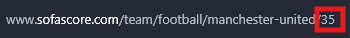

In [ ]:
def scrape_match(match_id, infos=['lineups', 'shotmap', 'incidents', 'statistics']):
    scraper = cloudscraper.create_scraper()
    d_match = {}
    url = "https://api.sofascore.com/api/v1/event/{}".format(match_id)

    response = scraper.get(url)
    data = response.json()

    d_match['event'] = data
    for info in infos:
        try:
            url = "https://api.sofascore.com/api/v1/event/{}/{}".format(match_id, info)
            response = scraper.get(url)

            if response.status_code!=404:
                data = response.json()

                d_match[info.split("/")[0]] = data
            else:
                print("{} error 404 accessing {}".format(match_id, info.split("/")[0]))
        except:
            print("{} accessing {}".format(match_id, info.split("/")[0]))

    return d_match

In [ ]:
def scrape_team_match(team_id, pages=1):
    scraper = cloudscraper.create_scraper()
    d_matches = {}

    for page_number in range(pages):
        url = "https://www.sofascore.com/api/v1/team/{}/events/last/{}".format(team_id, page_number)
        response = scraper.get(url)
        data = response.json()

        for event in data['events']:
            match_id = event['id']
            d_match = scrape_match(match_id)

            d_matches[match_id] = {}
            d_matches[match_id]['event'] = event

            for key, value in d_match.items():
                d_matches[match_id][key] = value

    return d_matches

In [ ]:
team_id = 38 # masukkan id tim (dari nomor url sofascore)

In [ ]:
d_matches = scrape_team_match(team_id)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
today = datetime.today()
formatted_date = today.strftime('%Y%m%d')

with open('drive/MyDrive/Workshop football analytic/{}-{} matches.pickle'.format(formatted_date, team_id), 'wb') as handle:
    pickle.dump(d_matches, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('drive/MyDrive/Workshop football analytic/{}-{} matches.json'.format(formatted_date, team_id), 'w') as fp:
    json.dump(d_matches, fp)

In [ ]:
# formatted_date = "20241006"

# with open('drive/MyDrive/Workshop/{}-{} matches.pickle'.format(formatted_date, team_id), 'rb') as handle:
#     d_matches = pickle.load(handle)

In [ ]:
d_matches.keys() #ambil 30 match

dict_keys([12112072, 11352616, 11352340, 11352378, 11352401, 12168338, 12190322, 11352454, 12226774, 11352494, 11352539, 12240570, 11352558, 12454535, 12268517, 12268524, 12268510, 12327428, 12518937, 12436880, 12695703, 12436904, 12698475, 12436910, 12436931, 12436980, 12785382, 12436989, 12764858, 12437013])

In [ ]:
match_id = 12168338 # ambil salah satu dari atas
d_matches[match_id].keys()

dict_keys(['event', 'lineups', 'shotmap', 'incidents', 'statistics'])

In [ ]:
d_matches[match_id]['event']

{'event': {'tournament': {'name': 'FA Cup',
   'slug': 'fa-cup',
   'category': {'name': 'England',
    'slug': 'england',
    'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
    'id': 1,
    'country': {'alpha2': 'EN',
     'alpha3': 'ENG',
     'name': 'England',
     'slug': 'england'},
    'flag': 'england',
    'alpha2': 'EN'},
   'uniqueTournament': {'name': 'FA Cup',
    'slug': 'fa-cup',
    'primaryColorHex': '#bc1821',
    'secondaryColorHex': '#e60411',
    'category': {'name': 'England',
     'slug': 'england',
     'sport': {'name': 'Football', 'slug': 'football', 'id': 1},
     'id': 1,
     'country': {'alpha2': 'EN',
      'alpha3': 'ENG',
      'name': 'England',
      'slug': 'england'},
     'flag': 'england',
     'alpha2': 'EN'},
    'userCount': 367327,
    'id': 19,
    'country': {},
    'hasPerformanceGraphFeature': False,
    'hasEventPlayerStatistics': False,
    'displayInverseHomeAwayTeams': False},
   'priority': 425,
   'isGroup': False,
   'c

In [ ]:
home_name = d_matches[match_id]['event']['event']['homeTeam']['name']
away_name = d_matches[match_id]['event']['event']['awayTeam']['name']

home_score = d_matches[match_id]['event']['event']['homeScore']['current']
away_score = d_matches[match_id]['event']['event']['awayScore']['current']

link = f"https://www.sofascore.com/football/match/{d_matches[match_id]['event']['event']['slug']}/{d_matches[match_id]['event']['event']['customId']}#id:{d_matches[match_id]['event']['event']['id']}"

print(f"{home_name} ({home_score}) - ({away_score}) {away_name}\n{link}")

Manchester City (1) - (0) Chelsea
https://www.sofascore.com/football/match/chelsea-manchester-city/rN#id:12168338


In [ ]:
l_matches = []
l_shots = []
l_team_stats = []
l_player_stats = []


for id, info in d_matches.items():
    if info['event']['event']['status']['code'] != 70:
        d_match = {}

        d_match['id'] = id
        d_match['link'] = f"https://www.sofascore.com/football/match/{info['event']['event']['slug']}/{info['event']['event']['customId']}#id:{info['event']['event']['id']}"

        d_match['league'] = info['event']['event']['tournament']['name']
        d_match['season'] = info['event']['event']['season']['year']
        d_match['round'] = str(info['event']['event']['roundInfo']['round']) if 'roundInfo' in info['event']['event'].keys() else None

        d_match['homeId'] = info['event']['event']['homeTeam']['id']
        d_match['homeName'] = info['event']['event']['homeTeam']['shortName']
        d_match['homeLongName'] = info['event']['event']['homeTeam']['name']
        d_match['homeScore'] = info['event']['event']['homeScore']['current']
        d_match['awayId'] = info['event']['event']['awayTeam']['id']
        d_match['awayName'] = info['event']['event']['awayTeam']['shortName']
        d_match['awayLongName'] = info['event']['event']['awayTeam']['name']
        d_match['awayScore'] = info['event']['event']['awayScore']['current']

        d_match['time'] = datetime.fromtimestamp(info['event']['event']['startTimestamp']).strftime('%Y-%m-%d %H:%M:%S')

        d_match['match'] = f"{d_match['homeName']} ({d_match['homeScore']}) - ({d_match['awayScore']}) {d_match['awayName']}"

        l_matches.append(d_match)


for id, info in d_matches.items():
    if 'shotmap' in info.keys() and info['event']['event']['status']['code'] != 70:
        shots = info['shotmap']['shotmap']

        for shot in shots:
            d_shot = {}
            d_shot['id'] = shot['id']
            d_shot['matchId'] = id
            d_shot['time'] = shot['time']
            d_shot['timeSeconds'] = shot['timeSeconds']
            d_shot['addedTime'] = shot['addedTime'] if 'addedTime' in shot.keys() else None
            d_shot['teamId'] = info['event']['event']['homeTeam']['id'] if shot['isHome'] else info['event']['event']['awayTeam']['id']
            d_shot['teamName'] = info['event']['event']['homeTeam']['shortName'] if shot['isHome'] else info['event']['event']['awayTeam']['shortName']

            d_shot['playerId'] = shot['player']['id']
            d_shot['playerFullName'] = shot['player']['name']
            d_shot['playerName'] = shot['player']['shortName']
            d_shot['shotType'] = shot['shotType']
            d_shot['goalType'] = shot['goalType'] if 'goalType' in shot.keys() else None
            d_shot['situation'] = shot['situation']
            d_shot['bodyPart'] = shot['bodyPart']
            d_shot['xg'] = shot['xg'] if 'xg' in shot.keys() else None
            d_shot['xgot'] = shot['xgot'] if 'xgot' in shot.keys() else None
            d_shot['goalMouthLocation'] = shot['goalMouthLocation'] if 'goalMouthLocation' in shot.keys() else None
            d_shot['x'] = shot['playerCoordinates']['x']
            d_shot['y'] = shot['playerCoordinates']['y']
            d_shot['goalMouthY'] = shot['goalMouthCoordinates']['y'] if 'goalMouthCoordinates' in shot.keys() else None
            d_shot['goalMouthZ'] = shot['goalMouthCoordinates']['z'] if 'goalMouthCoordinates' in shot.keys() else None
            d_shot['blockX'] = shot['blockCoordinates']['x'] if 'blockCoordinates' in shot.keys() else None
            d_shot['blockY'] = shot['blockCoordinates']['y'] if 'blockCoordinates' in shot.keys() else None

            l_shots.append(d_shot)

for id, info in d_matches.items():
    if 'statistics' in info.keys() and info['event']['event']['status']['code'] != 70:
        d_home_stats = {}
        d_away_stats = {}

        d_home_stats['league'] = info['event']['event']['tournament']['name']
        d_home_stats['season'] = info['event']['event']['season']['year']
        d_home_stats['round'] = str(info['event']['event']['roundInfo']['round']) if 'roundInfo' in info['event']['event'].keys() else None
        d_home_stats['matchId'] = id
        d_home_stats['teamId'] = info['event']['event']['homeTeam']['id']
        d_home_stats['teamName'] = info['event']['event']['homeTeam']['shortName']
        d_home_stats['teamLongName'] = info['event']['event']['homeTeam']['name']
        d_home_stats['formation'] = info['lineups']['home']['formation']
        d_home_stats['isHome'] = True
        d_home_stats['opponentId'] = info['event']['event']['awayTeam']['id']

        d_away_stats['league'] = info['event']['event']['tournament']['name']
        d_away_stats['season'] = info['event']['event']['season']['year']
        d_away_stats['round'] = str(info['event']['event']['roundInfo']['round'])  if 'roundInfo' in info['event']['event'].keys() else None
        d_away_stats['matchId'] = id
        d_away_stats['teamId'] = info['event']['event']['awayTeam']['id']
        d_away_stats['teamName'] = info['event']['event']['awayTeam']['shortName']
        d_away_stats['teamLongName'] = info['event']['event']['awayTeam']['name']
        d_away_stats['formation'] = info['lineups']['away']['formation']
        d_away_stats['isHome'] = False
        d_away_stats['opponentId'] = info['event']['event']['homeTeam']['id']

        try:
            d_home_stats['score'] = info['event']['event']['homeScore']['display']
            d_away_stats['score'] = info['event']['event']['awayScore']['display']
        except:
            print(id)
            break

        for group in info['statistics']['statistics'][0]['groups']:
            for item in group['statisticsItems']:
                d_home_stats[item['name']] = item['homeValue']
                d_away_stats[item['name']] = item['awayValue']

                if 'homeTotal' in item.keys() and 'awayTotal' in item.keys():
                    d_home_stats["{} Total".format(item['name'])] = item['homeTotal']
                    d_away_stats["{} Total".format(item['name'])] = item['awayTotal']

        l_team_stats.append(d_home_stats)
        l_team_stats.append(d_away_stats)

for id, info in d_matches.items():
    if 'lineups' in info.keys() and info['event']['event']['status']['code'] != 70:

        for situation in ['home', 'away']:
            for player in info['lineups'][situation]['players']:
                if 'statistics' in player.keys():
                    d_player_stats = {}

                    d_player_stats['matchId'] = id
                    d_player_stats['teamId'] = info['event']['event']['{}Team'.format(situation)]['id']
                    d_player_stats['teamName'] = info['event']['event']['{}Team'.format(situation)]['shortName']
                    d_player_stats['isHome'] = situation == 'home'
                    d_player_stats['playerId'] = player['player']['id']
                    d_player_stats['playerFullName'] = player['player']['name']
                    d_player_stats['playerName'] = player['player']['shortName']
                    d_player_stats['position'] = player['position']

                    d_player_stats['substitute'] = player['substitute']

                    for metric, value in player['statistics'].items():
                        if metric != 'ratingVersions':
                            d_player_stats[metric] = value

                    l_player_stats.append(d_player_stats)

In [ ]:
df_matches = pd.DataFrame(l_matches)
df_matches.head()

,id,link,league,season,round,homeId,homeName,homeLongName,homeScore,awayId,awayName,awayLongName,awayScore,time,match
0,12112072,https://www.sofascore.com/football/match/chels...,FA Cup,23/24,27,38,Chelsea,Chelsea,4,31,Leicester,Leicester City,2,2024-03-17 12:45:00,Chelsea (4) - (2) Leicester
1,11352616,https://www.sofascore.com/football/match/chels...,Premier League,23/24,30,38,Chelsea,Chelsea,2,6,Burnley,Burnley,2,2024-03-30 15:00:00,Chelsea (2) - (2) Burnley
2,11352340,https://www.sofascore.com/football/match/chels...,Premier League,23/24,31,38,Chelsea,Chelsea,4,35,Man Utd,Manchester United,3,2024-04-04 19:15:00,Chelsea (4) - (3) Man Utd
3,11352378,https://www.sofascore.com/football/match/chels...,Premier League,23/24,32,15,Sheffield Utd,Sheffield United,2,38,Chelsea,Chelsea,2,2024-04-07 16:30:00,Sheffield Utd (2) - (2) Chelsea
4,11352401,https://www.sofascore.com/football/match/evert...,Premier League,23/24,33,38,Chelsea,Chelsea,6,48,Everton,Everton,0,2024-04-15 19:00:00,Chelsea (6) - (0) Everton


In [ ]:
df_player_stats = pd.DataFrame(l_player_stats)
df_player_stats.head()

,matchId,teamId,teamName,isHome,playerId,playerFullName,playerName,position,substitute,totalPass,accuratePass,totalLongBalls,accurateLongBalls,totalKeeperSweeper,accurateKeeperSweeper,minutesPlayed,touches,rating,possessionLostCtrl,goalAssist,totalCross,accurateCross,duelLost,duelWon,challengeLost,dispossessed,totalContest,wonContest,bigChanceCreated,totalClearance,totalTackle,wasFouled,keyPass,aerialWon,errorLeadToAGoal,ownGoals,fouls,interceptionWon,aerialLost,onTargetScoringAttempt,goals,shotOffTarget,blockedScoringAttempt,hitWoodwork,bigChanceMissed,penaltyWon,penaltyMiss,goodHighClaim,savedShotsFromInsideTheBox,penaltySave,saves,outfielderBlock,penaltyConceded,totalOffside,goalsPrevented,expectedGoals,expectedAssists,clearanceOffLine,lastManTackle,errorLeadToAShot,punches
0,12112072,38,Chelsea,True,920546,Robert Sánchez,R. Sánchez,G,False,43.0,32.0,12.0,2.0,1.0,1.0,90.0,49.0,5.9,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,12112072,38,Chelsea,True,996958,Malo Gusto,M. Gusto,D,False,55.0,51.0,3.0,3.0,NaN,NaN,90.0,88.0,7.6,13.0,1.0,9.0,3.0,4.0,7.0,3.0,1.0,1.0,1.0,1.0,1.0,5.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12112072,38,Chelsea,True,827243,Axel Disasi,A. Disasi,D,False,98.0,88.0,12.0,5.0,NaN,NaN,90.0,104.0,5.5,11.0,NaN,1.0,1.0,4.0,2.0,2.0,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12112072,38,Chelsea,True,826134,Trevoh Chalobah,T. Chalobah,D,False,59.0,51.0,1.0,NaN,NaN,NaN,90.0,65.0,6.4,9.0,NaN,NaN,NaN,1.0,3.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,12112072,38,Chelsea,True,794939,Marc Cucurella,M. Cucurella,D,False,43.0,35.0,4.0,2.0,NaN,NaN,89.0,66.0,7.5,10.0,NaN,NaN,NaN,5.0,8.0,1.0,NaN,NaN,NaN,NaN,6.0,4.0,1.0,1.0,3.0,NaN,NaN,3.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_team_stats = pd.DataFrame(l_team_stats)
df_team_stats.head()

,league,season,round,matchId,teamId,teamName,teamLongName,formation,isHome,opponentId,score,Ball possession,Big chances,Total shots,Goalkeeper saves,Corner kicks,Fouls,Passes,Tackles,Free kicks,Yellow cards,Red cards,Shots on target,Hit woodwork,Shots off target,Blocked shots,Shots inside box,Shots outside box,Big chances scored,Big chances missed,Through balls,Fouled in final third,Offsides,Accurate passes,Throw-ins,Final third entries,Long balls,Long balls Total,Crosses,Crosses Total,Duels,Dispossessed,Ground duels,Ground duels Total,Aerial duels,Aerial duels Total,Dribbles,Dribbles Total,Tackles won,Tackles won Total,Total tackles,Interceptions,Recoveries,Clearances,Total saves,Goal kicks,Expected goals,Goals prevented,Touches in penalty area,Final third phase,Final third phase Total,Errors lead to a shot,High claims,Big saves,Punches,Errors lead to a goal
0,FA Cup,23/24,27,12112072,38,Chelsea,Chelsea,4-2-3-1,True,31,4,60,6.0,26,0,7,10,584,20,12,0.0,0.0,8,1,10,8,18,8,3.0,3.0,2.0,3,0.0,497,22,58,21,51,5,20,50,11,40,82,12,21,8,18,10,20,20,6,55,11,0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FA Cup,23/24,27,12112072,31,Leicester,Leicester City,4-3-3,False,38,2,40,1.0,5,4,3,12,400,21,10,2.0,1.0,1,0,4,0,5,0,0.0,1.0,0.0,1,1.0,325,8,40,14,40,5,13,50,12,42,82,9,21,11,19,9,21,21,12,52,33,4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Premier League,23/24,30,11352616,38,Chelsea,Chelsea,4-2-3-1,True,6,2,69,6.0,33,4,12,12,630,8,7,2.0,0.0,13,1,10,10,22,11,2.0,4.0,3.0,1,3.0,570,18,70,29,37,5,23,48,5,31,57,8,25,16,21,6,8,8,6,45,10,4,6,4.26,-0.1759,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Premier League,23/24,30,11352616,6,Burnley,Burnley,4-4-2,False,38,2,31,4.0,18,11,4,7,271,10,11,4.0,1.0,7,1,6,5,14,4,0.0,4.0,0.0,5,0.0,204,10,49,29,54,8,10,52,3,26,57,17,25,6,11,8,10,10,11,45,26,11,13,1.64,2.8159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Premier League,23/24,31,11352340,38,Chelsea,Chelsea,4-2-3-1,True,35,4,57,4.0,28,2,12,7,549,12,12,3.0,NaN,10,1,9,9,19,9,2.0,2.0,1.0,5,3.0,470,14,51,24,47,4,16,49,10,30,64,9,16,6,14,6,12,12,8,62,6,2,11,3.02,-0.9186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_shots = pd.DataFrame(l_shots)
df_shots.head()

,id,matchId,time,timeSeconds,addedTime,teamId,teamName,playerId,playerFullName,playerName,shotType,goalType,situation,bodyPart,xg,xgot,goalMouthLocation,x,y,goalMouthY,goalMouthZ,blockX,blockY
0,2605880,12112072,90,5847,8.0,38,Chelsea,966547,Noni Madueke,N. Madueke,goal,regular,assisted,left-foot,NaN,NaN,high-left,21.4,62.3,53.4,27.2,NaN,NaN
1,2605877,12112072,90,5773,7.0,38,Chelsea,982780,Cole Palmer,C. Palmer,block,None,free-kick,left-foot,NaN,NaN,low-centre,27.2,72.3,48.5,19.0,17.9,65.2
2,2605852,12112072,90,5682,5.0,38,Chelsea,982780,Cole Palmer,C. Palmer,block,None,assisted,left-foot,NaN,NaN,low-left,13.6,51.5,52.1,19.0,12.0,51.1
3,2605820,12112072,90,5479,2.0,38,Chelsea,994556,Carney Chukwuemeka,C. Chukwuemeka,goal,regular,assisted,right-foot,NaN,NaN,low-centre,4.9,43.3,48.9,2.5,NaN,NaN
4,2605815,12112072,90,5367,NaN,38,Chelsea,1085381,Nicolas Jackson,N. Jackson,miss,None,regular,right-foot,NaN,NaN,high-right,9.8,45.5,41.0,72.2,NaN,NaN


In [ ]:
df_shots.loc[(df_shots['teamId']==team_id) & (df_shots['goalType']!='own')].groupby(['playerId','playerName'], as_index=False).agg(count=('shotType','count')).sort_values('count', ascending=False)

,playerId,playerName,count
19,982780,C. Palmer,92
17,966547,N. Madueke,61
28,1085381,N. Jackson,54
3,769333,C. Nkunku,41
16,958966,M. Mudryk,33
1,138534,R. Sterling,22
33,1414933,M. Guiu,18
18,974505,E. Fernández,16
14,904970,C. Gallagher,16
23,996958,M. Gusto,14


In [ ]:
df_shots = pd.merge(df_shots, df_matches[['id','match']].rename({'id':'matchId'},axis=1))

In [ ]:
d_dfs = {}
d_dfs['shots'] = df_shots
d_dfs['player_stats'] = df_player_stats
d_dfs['team_stats'] = df_team_stats
d_dfs['matches'] = df_matches

In [ ]:
with pd.ExcelWriter("drive/MyDrive/Workshop football analytic/{}-{} data.xlsx".format(formatted_date, team_id)) as writer:

    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet
    for key, dataframe in d_dfs.items():
        dataframe.to_excel(writer, sheet_name=key, index=False)

## Shotmap Visualitation

In [ ]:
def single_color_cmap(color):
    return LinearSegmentedColormap.from_list(
        name='single_color_cmap',
        colors=['white', color]
    )

In [ ]:
df_shots_team = df_shots.loc[df_shots['teamId']==team_id].reset_index(drop=True)
df_shots_team['_x'] = 100-df_shots_team['x']
df_shots_team['_y'] = 100-df_shots_team['y']

df_goals_team = df_shots.loc[(df_shots['teamId']==team_id) & (df_shots['shotType']=='goal')].reset_index(drop=True)
df_goals_team['_x'] = 100-df_goals_team['x']
df_goals_team['_y'] = 100-df_goals_team['y']

In [ ]:
home_match_id = df_matches.loc[df_matches['homeId']==team_id]['id'].iloc[0]
team_name = df_matches.loc[df_matches['homeId']==team_id]['homeName'].iloc[0]
team_color = d_matches[home_match_id]['event']['event']['homeTeam']['teamColors']['primary']
logo_url = f"https://api.sofascore.app/api/v1/team/{team_id}/image"

In [ ]:
custom_cmap = single_color_cmap(team_color)

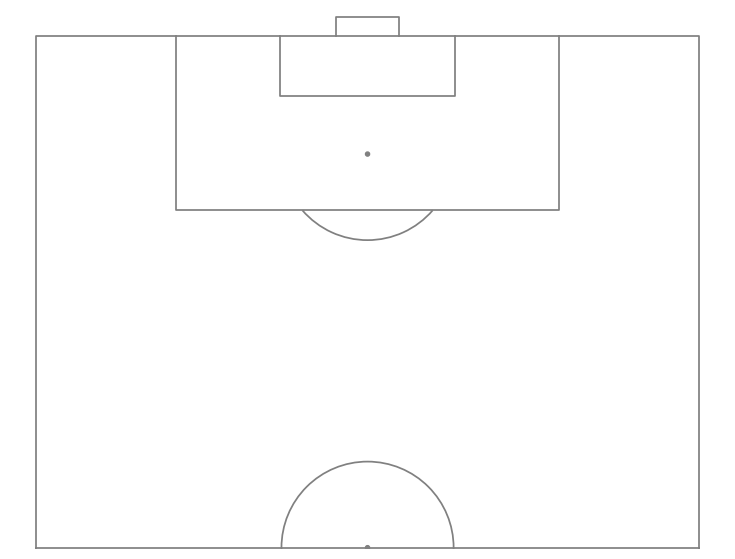

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

pitch = VerticalPitch(pitch_type='opta', half=True, goal_type='box', linewidth=1.25, line_color='gray', pad_bottom=0.2, pad_top=4, line_zorder=2)
pitch.draw(ax=ax)

plt.show()

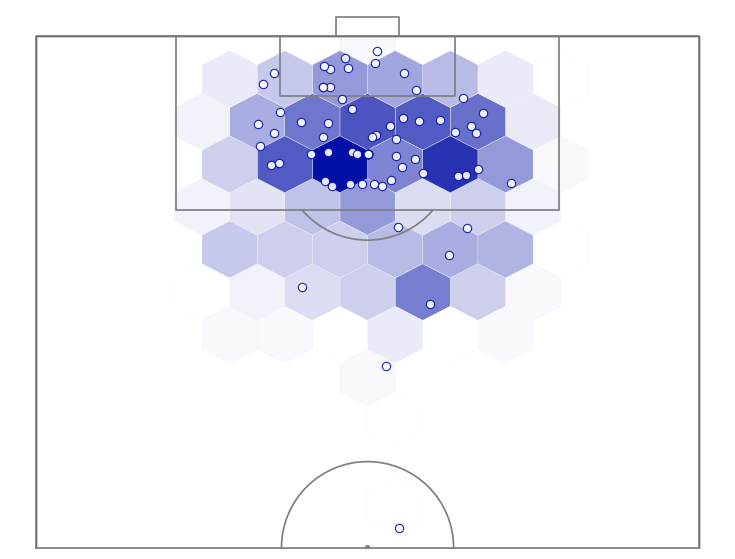

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

pitch = VerticalPitch(pitch_type='opta', half=True, goal_type='box', linewidth=1.25, line_color='gray', pad_bottom=0.2, pad_top=4, line_zorder=2)
pitch.draw(ax=ax)

bins1 = pitch.hexbin(x=df_shots_team['_x'], y=df_shots_team['_y'], ax=ax,
                     cmap=custom_cmap,
                     gridsize=(12, 12),
                     zorder=-1,
                     edgecolors='#f4f4f4',
                     alpha=1, lw=.25)

bins2 = pitch.scatter(x=df_goals_team['_x'], y=df_goals_team['_y'],
                      # s=25+df_goals_team['xg']*250,
                      ax=ax, zorder=2, edgecolors=team_color, alpha=0.9, lw=.8, color='white')

plt.show()

In [ ]:
n_games = df_shots_team['matchId'].nunique()
n_shots = len(df_shots_team)
n_goals = len(df_goals_team)

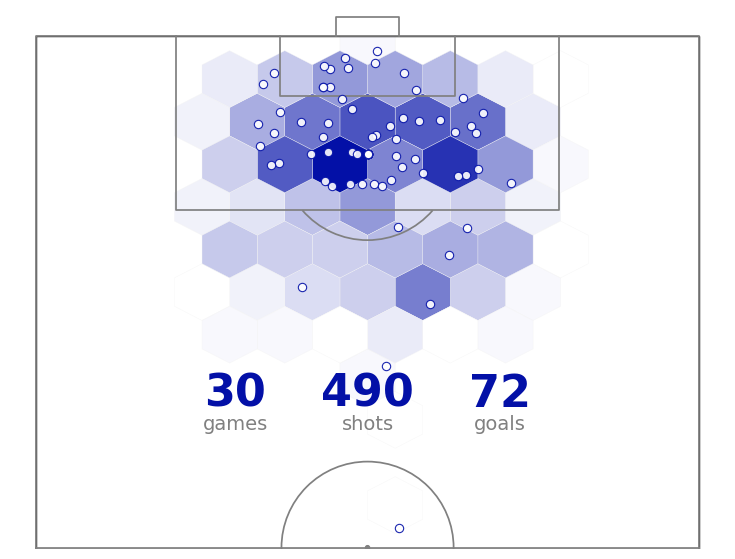

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

pitch = VerticalPitch(pitch_type='opta', half=True, goal_type='box', linewidth=1.25, line_color='gray', pad_bottom=0.2, pad_top=4, line_zorder=2)
pitch.draw(ax=ax)

bins1 = pitch.hexbin(x=df_shots_team['_x'], y=df_shots_team['_y'], ax=ax,
                     cmap=custom_cmap,
                     gridsize=(12, 12),
                     zorder=-1,
                     edgecolors='#f4f4f4',
                     alpha=1, lw=.25)

bins2 = pitch.scatter(x=df_goals_team['_x'], y=df_goals_team['_y'],
                      # s=25+df_goals_team['xg']*250,
                      ax=ax, zorder=2, edgecolors=team_color, alpha=0.9, lw=.8, color='white')

ax.annotate(
            text=str(n_games), xy=(70, 65), xytext=(0, 0), textcoords='offset points',
            size=32, ha='center', va='center', weight='bold', color=team_color)

ax.annotate(
            text=str(n_shots), xy=(50, 65), xytext=(0, 0), textcoords='offset points',
            size=32, ha='center', va='center', weight='bold', color=team_color)

ax.annotate(
            text=str(n_goals), xy=(30, 65), xytext=(0, 0), textcoords='offset points',
            size=32, ha='center', va='center', weight='bold', color=team_color)

ax.annotate(
            text='games', xy=(70, 62), xytext=(0, 0), textcoords='offset points',
            size=14, ha='center', va='center', weight='regular', color='gray')

ax.annotate(
            text='shots', xy=(50, 62), xytext=(0, 0), textcoords='offset points',
            size=14, ha='center', va='center', weight='regular', color='gray')

ax.annotate(
            text='goals', xy=(30, 62), xytext=(0, 0), textcoords='offset points',
            size=14, ha='center', va='center', weight='regular', color='gray')

plt.show()

In [ ]:
def getImage(url, zoom):
    club_icon = Image.open(urllib.request.urlopen(url))
    return OffsetImage(club_icon.convert("RGBA"), zoom=zoom)

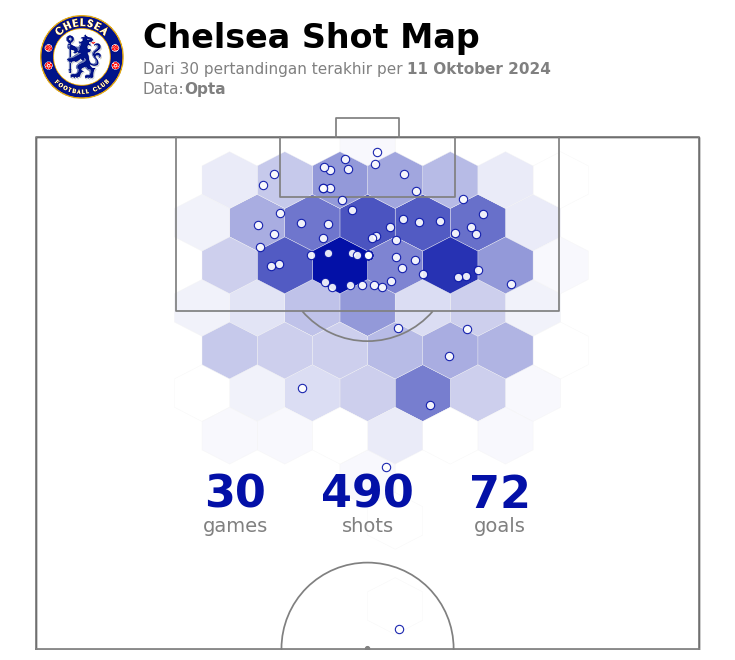

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=100)

pitch = VerticalPitch(pitch_type='opta', half=True, goal_type='box', linewidth=1.25, line_color='gray', pad_bottom=0.2, pad_top=4, line_zorder=2)
pitch.draw(ax=ax)

bins1 = pitch.hexbin(x=df_shots_team['_x'], y=df_shots_team['_y'], ax=ax,
                     cmap=custom_cmap,
                     gridsize=(12, 12),
                     zorder=-1,
                     edgecolors='#f4f4f4',
                     alpha=1, lw=.25)

bins2 = pitch.scatter(x=df_goals_team['_x'], y=df_goals_team['_y'],
                      # s=25+df_goals_team['xg']*250,
                      ax=ax, zorder=2, edgecolors=team_color, alpha=0.9, lw=.8, color='white')

ax.annotate(
            text=str(n_games), xy=(70, 65), xytext=(0, 0), textcoords='offset points',
            size=32, ha='center', va='center', weight='bold', color=team_color)

ax.annotate(
            text=str(n_shots), xy=(50, 65), xytext=(0, 0), textcoords='offset points',
            size=32, ha='center', va='center', weight='bold', color=team_color)

ax.annotate(
            text=str(n_goals), xy=(30, 65), xytext=(0, 0), textcoords='offset points',
            size=32, ha='center', va='center', weight='bold', color=team_color)

ax.annotate(
            text='games', xy=(70, 62), xytext=(0, 0), textcoords='offset points',
            size=14, ha='center', va='center', weight='regular', color='gray')

ax.annotate(
            text='shots', xy=(50, 62), xytext=(0, 0), textcoords='offset points',
            size=14, ha='center', va='center', weight='regular', color='gray')

ax.annotate(
            text='goals', xy=(30, 62), xytext=(0, 0), textcoords='offset points',
            size=14, ha='center', va='center', weight='regular', color='gray')

fig_text(x = 0.325, y = 0.96,
         fontsize = 24,
         s = f"{team_name} Shot Map",
         color = 'black',
         highlight_textprops = [],
         weight='bold',
         ha='left',
         va='bottom'
         )
fig_text(x = 0.325, y = 0.9,
         fontsize = 11,
         s = "Dari 30 pertandingan terakhir per <11 Oktober 2024>\nData:<Opta>",
         color = 'gray',
         highlight_textprops = [{"weight":"bold"}, {"weight":"bold"}],
         weight='regular',
         ha='left',
         va='bottom'
         )

ab_ig = AnnotationBbox(getImage(logo_url,.4), (0.1,1.1), xycoords='axes fraction', frameon=False)
ax.add_artist(ab_ig)

plt.show()